In [2]:
import open3d as o3d
import numpy as np

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [10]:
# Load point cloud from file
pcd = o3d.io.read_point_cloud("/home/toan/Documents/bachelor/image_processing/output2.pcd")

# Convert to NumPy
points = np.asarray(pcd.points)

# information
print(pcd) # PointCloud with 307200 points.
print(points.shape) # (307200, 3)

# Kiểm tra NaN hoặc Inf
print("Contains NaN:", np.isnan(points).any())
print("Contains Inf:", np.isinf(points).any())

# Loại bỏ NaN và Inf
filtered_points = points[~np.isnan(points).any(axis=1)]
filtered_points = filtered_points[~np.isinf(filtered_points).any(axis=1)]

# Gán lại vào point cloud
pcd.points = o3d.utility.Vector3dVector(filtered_points)

# downsampling votex
voxel_size = 0.05
downpcd = pcd.voxel_down_sample(voxel_size=voxel_size)

PointCloud with 307200 points.
(307200, 3)
Contains NaN: False
Contains Inf: True


In [12]:
points = np.asarray(downpcd.points)
print(points.shape) # (307200, 3)

(74735, 3)


In [13]:
# Filter by z-axis in [lower_threshold, upper_threshold]
z_lower_threshold = 9
z_upper_threshold = 20
filtered_points = points[(points[:, 2] > z_lower_threshold) & (points[:, 2] < z_upper_threshold)]
pcd.points = o3d.utility.Vector3dVector(filtered_points)


# # Tạo trục tọa độ gốc (dài 1 đơn vị)
axis_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10., origin=[0, 0, 0])

# Hiển thị point cloud cùng trục tọa độ
o3d.visualization.draw_geometries([pcd, axis_frame])

In [14]:
# Plane Segmentation using RANSAC
plane_model, inliers = pcd.segment_plane(distance_threshold=0.01, ransac_n=3, num_iterations=1000)
[a, b, c, d] = plane_model

# Hiển thị mặt phẳng
inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)
o3d.visualization.draw_geometries([inlier_cloud, axis_frame])



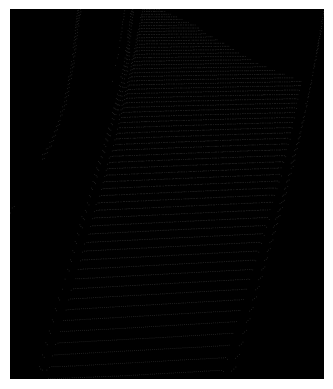

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Chiếu Point Cloud xuống mặt phẳng 2D Oxz và visualize ảnh
# Tạo mặt phẳng
# Chiếu xuống mặt phẳng Oxz (bỏ trục y)
points = np.asarray(inlier_cloud.points)
xz_points = points[:, [0, 2]]  # Chỉ giữ tọa độ (x, z)

# Tạo ảnh
# Tìm min, max của x và z
min_x, min_z = np.min(xz_points, axis=0)
max_x, max_z = np.max(xz_points, axis=0)

# Tạo ảnh
scale = 100
img_width = int((max_x - min_x) * scale)
img_height = int((max_z - min_z) * scale)
img = np.zeros((img_height, img_width, 3), dtype=np.uint8)

# Vẽ điểm
for point in xz_points:
    x, z = point
    x = int((x - min_x) * scale)
    z = int((z - min_z) * scale)
    if 0 <= x < img_width and 0 <= z < img_height:
        img[z, x] = [255, 255, 255]


img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Hiển thị ảnh trong notebook
plt.imshow(img_rgb)
plt.axis('off')  # Ẩn trục tọa độ
plt.show()